In [1]:
# import necessary libraries
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera

In [2]:
# ignore warnings
warnings.filterwarnings('ignore')

In [3]:
# graph settings
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'

In [4]:
# load data
returns = pd.read_csv('data/daily_returns.csv', index_col=0, parse_dates=True)

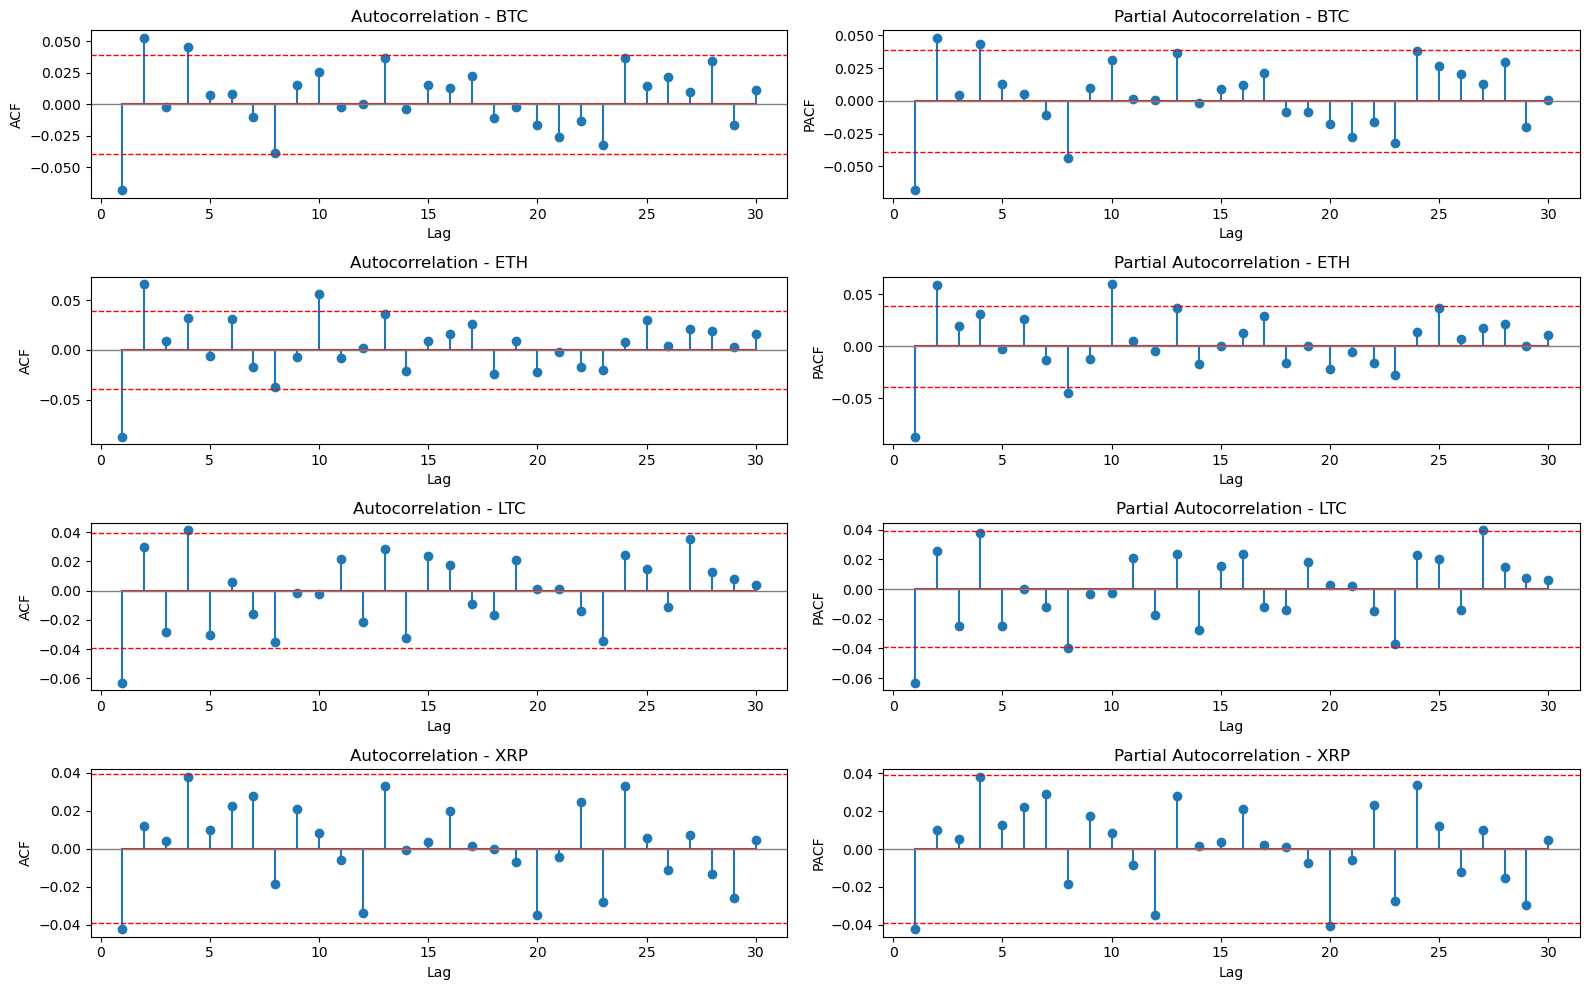

In [5]:
# plot acf / pacf on return series
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 10))

for i, asset in enumerate(returns.columns):
    series = returns[asset]
    acf_vals = acf(series, nlags=30)
    pacf_vals = pacf(series, nlags=30)

    axes[i, 0].stem(range(1, len(acf_vals)), acf_vals[1:])
    axes[i, 0].axhline(0, color='gray', linewidth=1)
    axes[i, 0].axhline(1.96/len(returns)**0.5, color='red', linestyle='--', linewidth=1)
    axes[i, 0].axhline(-1.96/len(returns)**0.5, color='red', linestyle='--', linewidth=1)
    axes[i, 0].set_title(f'Autocorrelation - {asset}')
    axes[i, 0].set_xlabel('Lag')
    axes[i, 0].set_ylabel('ACF')

    axes[i, 1].stem(range(1, len(pacf_vals)), pacf_vals[1:])
    axes[i, 1].axhline(0, color='gray', linewidth=1)
    axes[i, 1].axhline(1.96/len(returns)**0.5, color='red', linestyle='--', linewidth=1)
    axes[i, 1].axhline(-1.96/len(returns)**0.5, color='red', linestyle='--', linewidth=1)
    axes[i, 1].set_title(f'Partial Autocorrelation - {asset}')
    axes[i, 1].set_xlabel('Lag')
    axes[i, 1].set_ylabel('PACF')

plt.tight_layout()
plt.show()

In [6]:
# grid search for best arma(p, q)
p_range = range(0, 5)
q_range = range(0, 5)
arma_results = []

for asset in returns.columns:
    print(f'Searching ARMA(p, q) for {asset} ...')
    series = returns[asset]
    best_aic = np.inf
    best_order = None

    for p in p_range:
        for q in q_range:
            try:
                model = ARIMA(series, order=(p, 0, q))
                result = model.fit()
                aic = result.aic
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, q)
            except Exception as e:
                print(f'Skipping ARMA({p},{q}) for {asset} due to {e}')
                continue
    
    print(f'Best ARMA{best_order} for {asset} with AIC = {best_aic:.2f}\n')
    arma_results.append({
        'Asset': asset,
        'ARMA Order': best_order,
        'AIC': best_aic
    })

arma_results_df = pd.DataFrame(arma_results)
arma_results_df

Searching ARMA(p, q) for BTC ...
Best ARMA(0, 4) for BTC with AIC = 13333.51

Searching ARMA(p, q) for ETH ...
Best ARMA(2, 4) for ETH with AIC = 14684.26

Searching ARMA(p, q) for LTC ...
Best ARMA(2, 2) for LTC with AIC = 15065.58

Searching ARMA(p, q) for XRP ...
Best ARMA(3, 4) for XRP with AIC = 15580.39



,Asset,ARMA Order,AIC
0,BTC,"(0, 4)",13333.513304
1,ETH,"(2, 4)",14684.263455
2,LTC,"(2, 2)",15065.577201
3,XRP,"(3, 4)",15580.394096


In [7]:
# check for heteroscedasticity
ljungbox_results = []
residuals = pd.DataFrame()

for i, row in arma_results_df.iterrows():
    asset = row['Asset']
    p, q = row['ARMA Order']

    print(f'Fitting ARMA({p}, {q}) for {asset} ...')
    series = returns[asset]
    model = ARIMA(series, order=(p, 0, q))
    result = model.fit()
    resid = result.resid
    residuals[asset] = resid

    lb_test = acorr_ljungbox(resid**2, lags=[10, 20, 30], return_df=True)
    for lag, row in lb_test.iterrows():
        ljungbox_results.append({
            'Asset': asset,
            'Lag': lag,
            'LB Statistic': row['lb_stat'],
            'P-Value': row['lb_pvalue'],
            'Heteroscedasticity': 'Yes' if row['lb_pvalue'] < 0.05 else 'No'
        })

ljungbox_results_df = pd.DataFrame(ljungbox_results)
ljungbox_results_df


Fitting ARMA(0, 4) for BTC ...
Fitting ARMA(2, 4) for ETH ...
Fitting ARMA(2, 2) for LTC ...
Fitting ARMA(3, 4) for XRP ...


,Asset,Lag,LB Statistic,P-Value,Heteroscedasticity
0,BTC,10,26.514671,3.106295e-03,Yes
1,BTC,20,34.704149,2.173777e-02,Yes
2,BTC,30,36.214529,2.011374e-01,No
3,ETH,10,57.529451,1.059990e-08,Yes
4,ETH,20,65.312607,1.040523e-06,Yes
5,ETH,30,84.876699,3.841738e-07,Yes
6,LTC,10,88.587838,1.020118e-14,Yes
7,LTC,20,103.766173,2.652528e-13,Yes
8,LTC,30,111.290409,2.829745e-11,Yes
9,XRP,10,112.363984,1.778737e-19,Yes


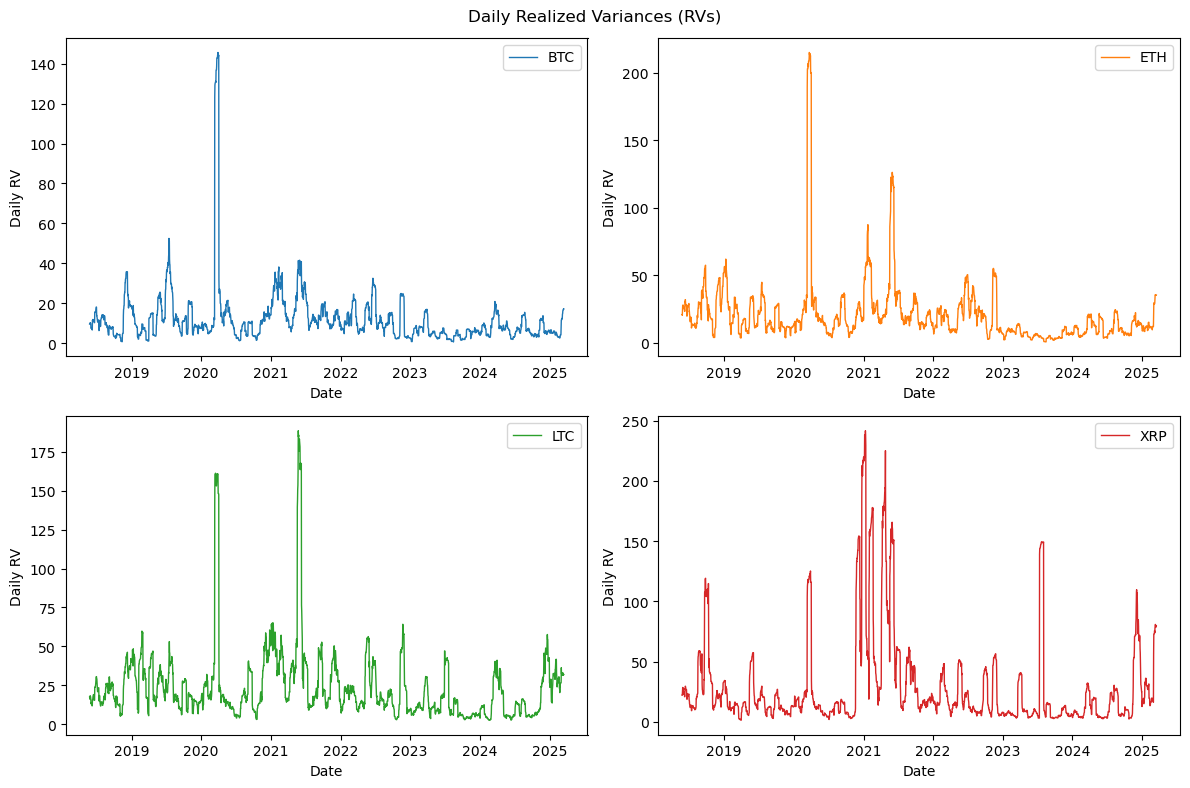

In [8]:
# plot realized variances
realized_vars = (residuals**2).rolling(window=22).mean().dropna()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Daily Realized Variances (RVs)')
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
axes = axes.flatten()

for i, asset in enumerate(returns.columns):
    axes[i].plot(realized_vars[asset], label=asset, color=colors[i], linewidth=1)
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Daily RV')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [9]:
# check for normality in residuals
for asset in residuals.columns:
    result = jarque_bera([residuals[asset]])
    p_value = result[1]

    if p_value < 0.05:
        print(f'{asset} residuals are NOT normally distributed')
    else:
        print(f'{asset} residuals are normallly distributed')

BTC residuals are NOT normally distributed
ETH residuals are NOT normally distributed
LTC residuals are NOT normally distributed
XRP residuals are NOT normally distributed


In [10]:
# save data
residuals.to_csv('data/daily_residuals.csv')
realized_vars.to_csv('data/daily_realized_vars.csv')